<a href="https://colab.research.google.com/github/Kishor-Alagappan/house_price_prediction/blob/main/house_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [120]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error

DATA INGESTION

In [121]:
# Read the CSV file named "train.csv" into a Pandas dataframe and assign it to the variable 'train_df'
train_df = pd.read_csv('/content/train.csv')

# Read the CSV file named "test.csv" into a Pandas dataframe and assign it to the variable 'test_df'
test_df = pd.read_csv('/content/test.csv')

In [122]:
#Drop Id and save the test ids for the submission
train_df.drop(['Id'], axis=1, inplace=True)
test_id = test_df['Id'].copy()
test_df.drop(['Id'], axis=1, inplace=True)

In [123]:
# Display the first 10 rows of the dataframe to provide an initial view of the data
train_df.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


Deep Exploratory Data Analysis

In [124]:
# Display information about the dataframe 'df'
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [125]:
print(f"""Numerical columns {len(train_df.select_dtypes(include=['int64', 'float64']).columns)}
Categorical columns {len(train_df.select_dtypes(include=['object']).columns)}""")

Numerical columns 37
Categorical columns 43


<Axes: xlabel='SalePrice', ylabel='Count'>

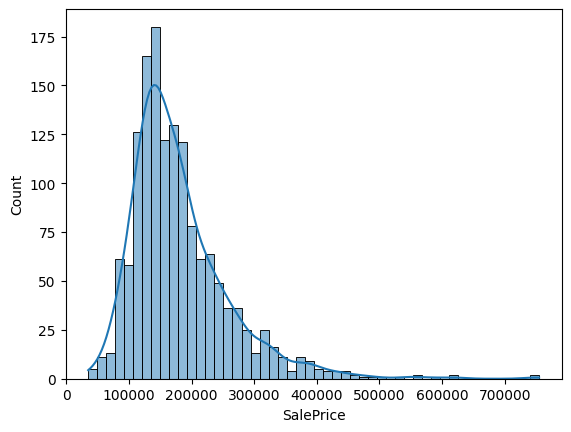

In [126]:
#Distribution of Sale Price (target variable)
sns.histplot(train_df['SalePrice'], bins=50, kde=True)

<Axes: >

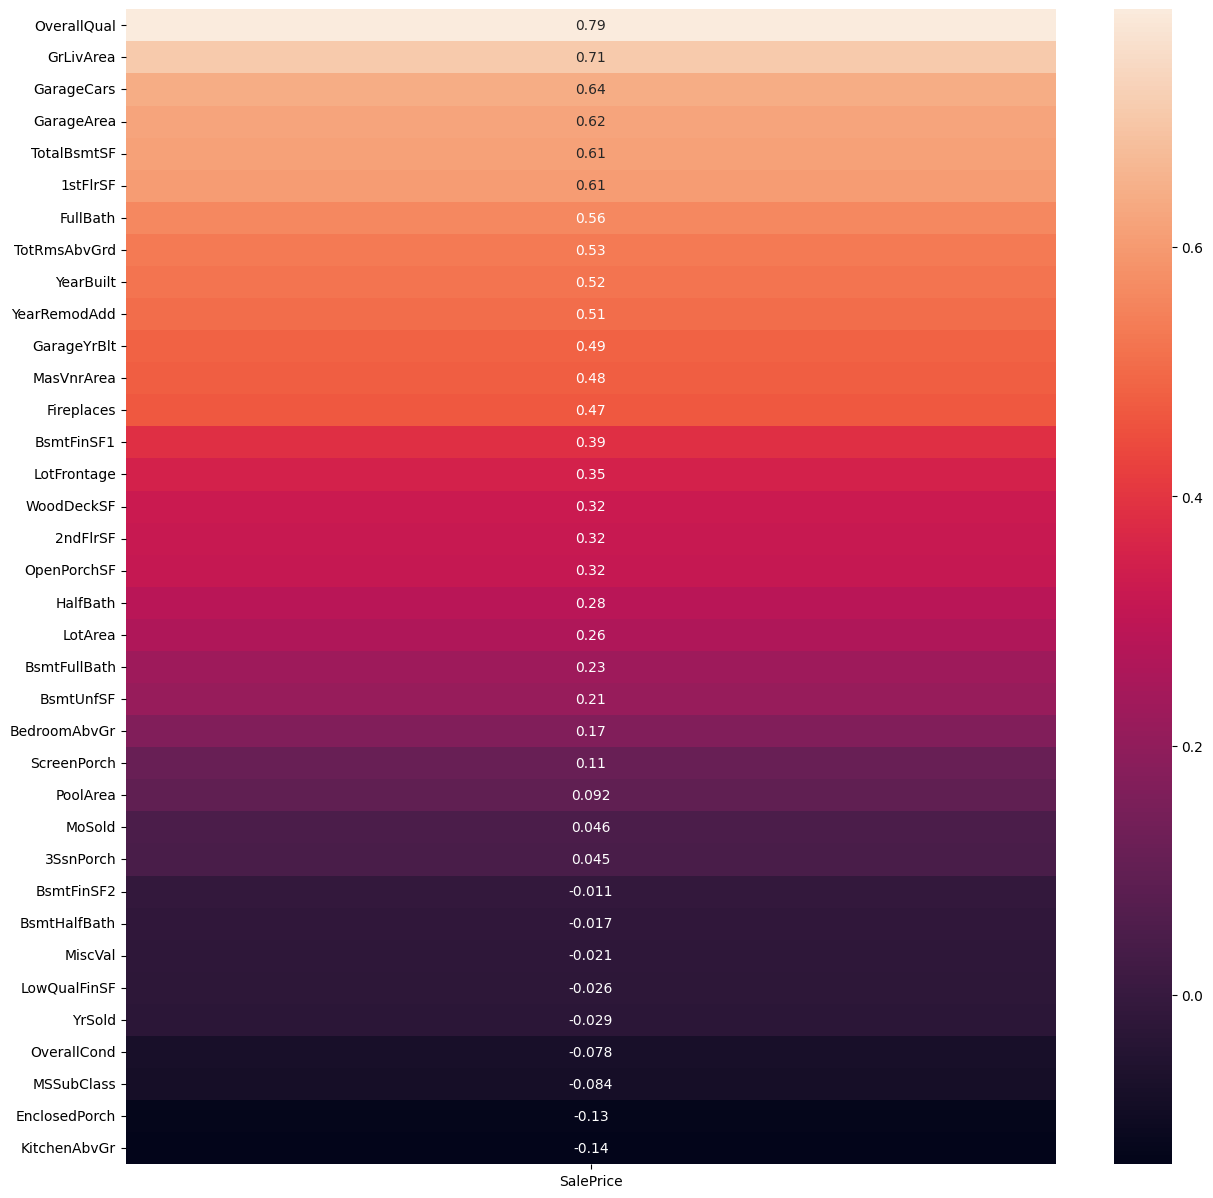

In [127]:
#We can plot a correlation graph between numeric features and target.
#Variables on both ends of the spectrum are of the greatest interest
dataset_numeric = train_df.select_dtypes(include=['int64', 'float64'])
fig, ax = plt.subplots(figsize=(15, 15))
corr = dataset_numeric.corr()[['SalePrice']]
corr.drop(['SalePrice'], axis=0, inplace=True)
sns.heatmap(corr.sort_values(by='SalePrice', ascending=False), ax=ax, annot=True)

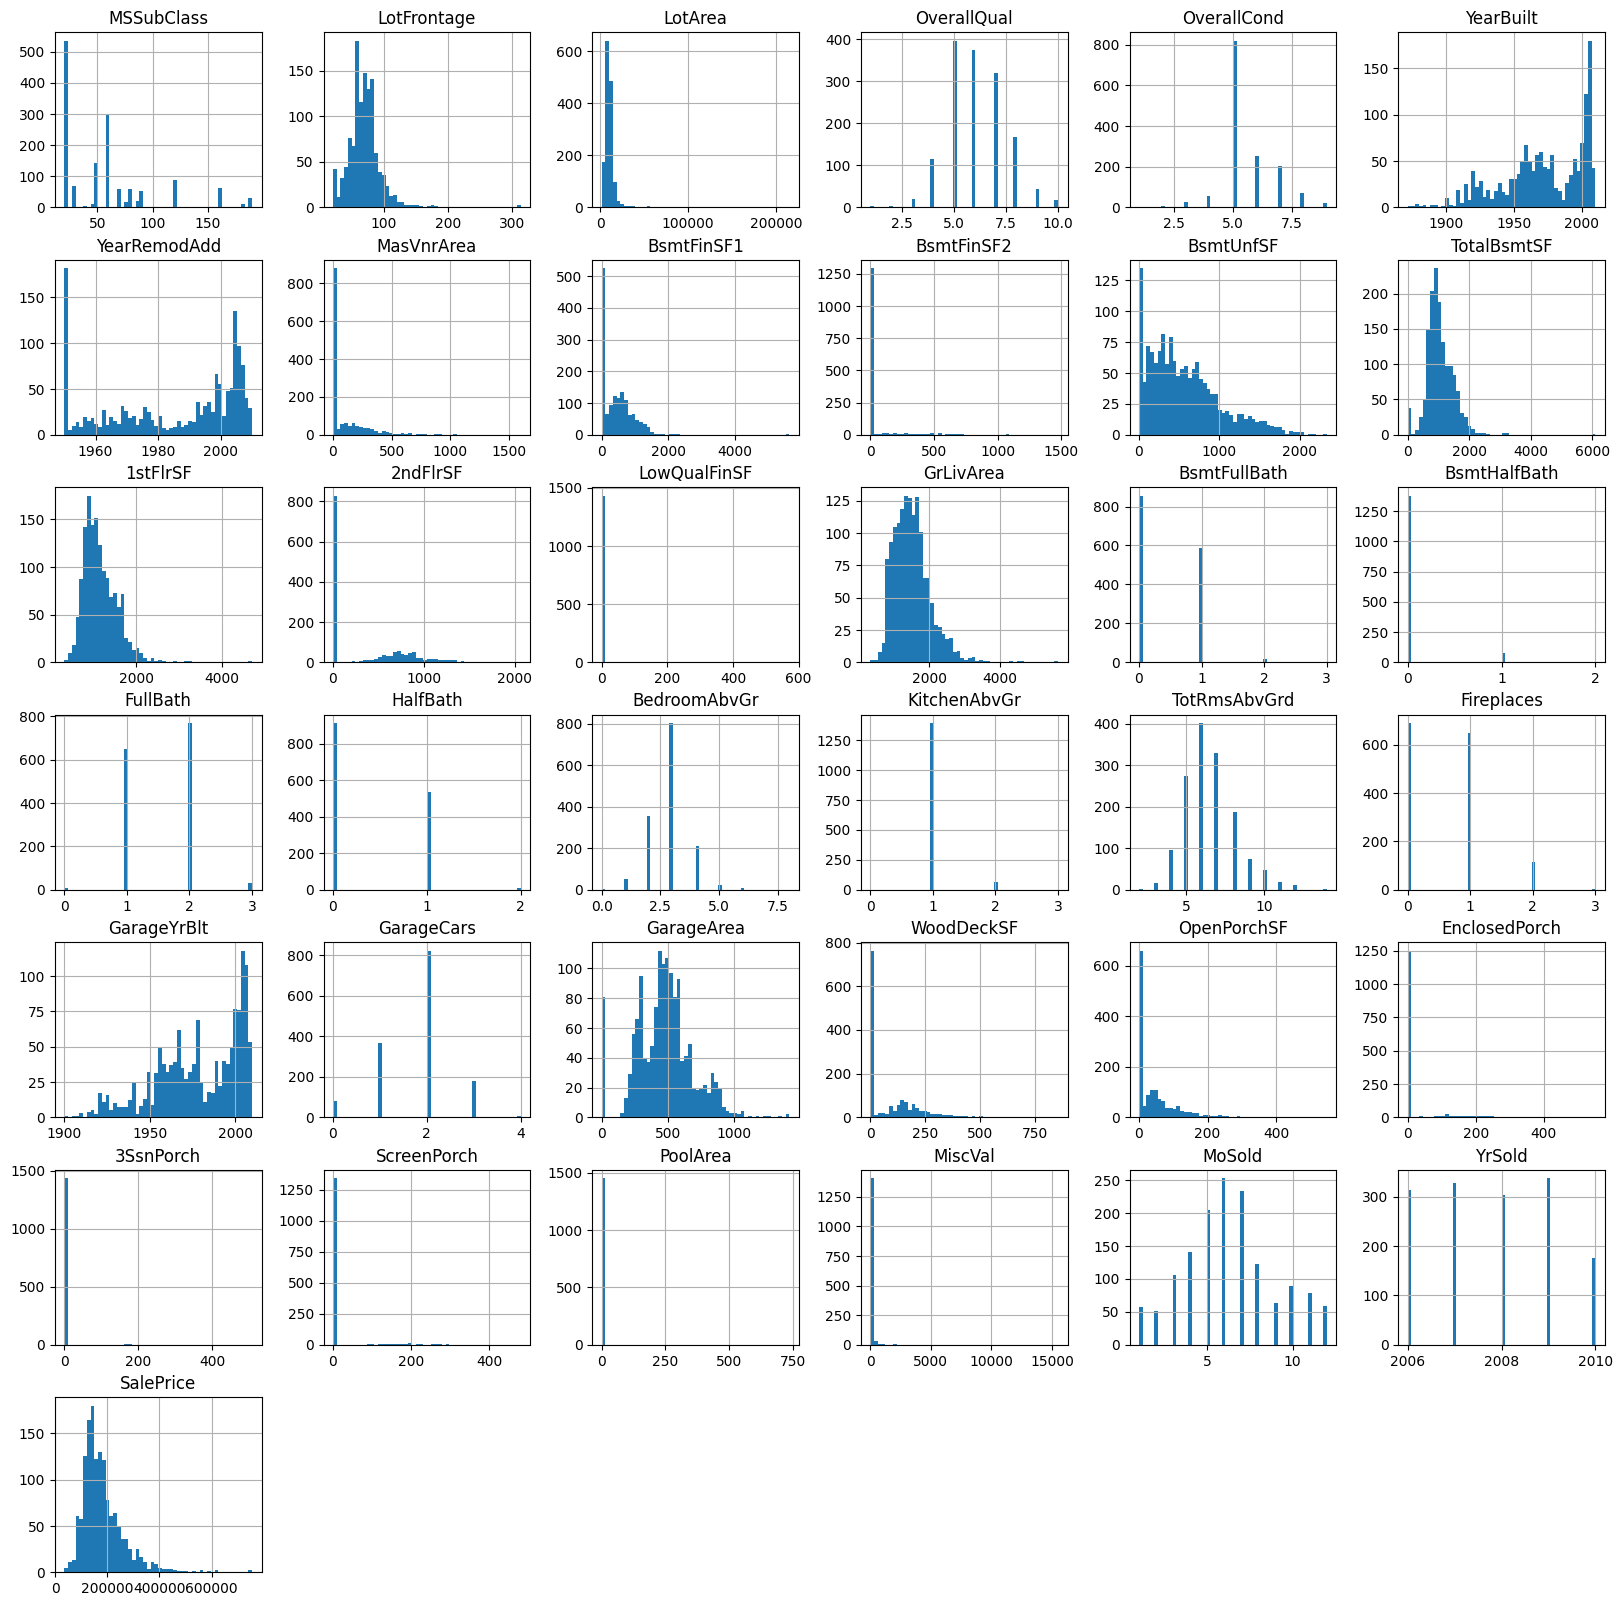

In [128]:
#Plot feature distributions
hist = dataset_numeric.hist(figsize=(20,20), bins=50)

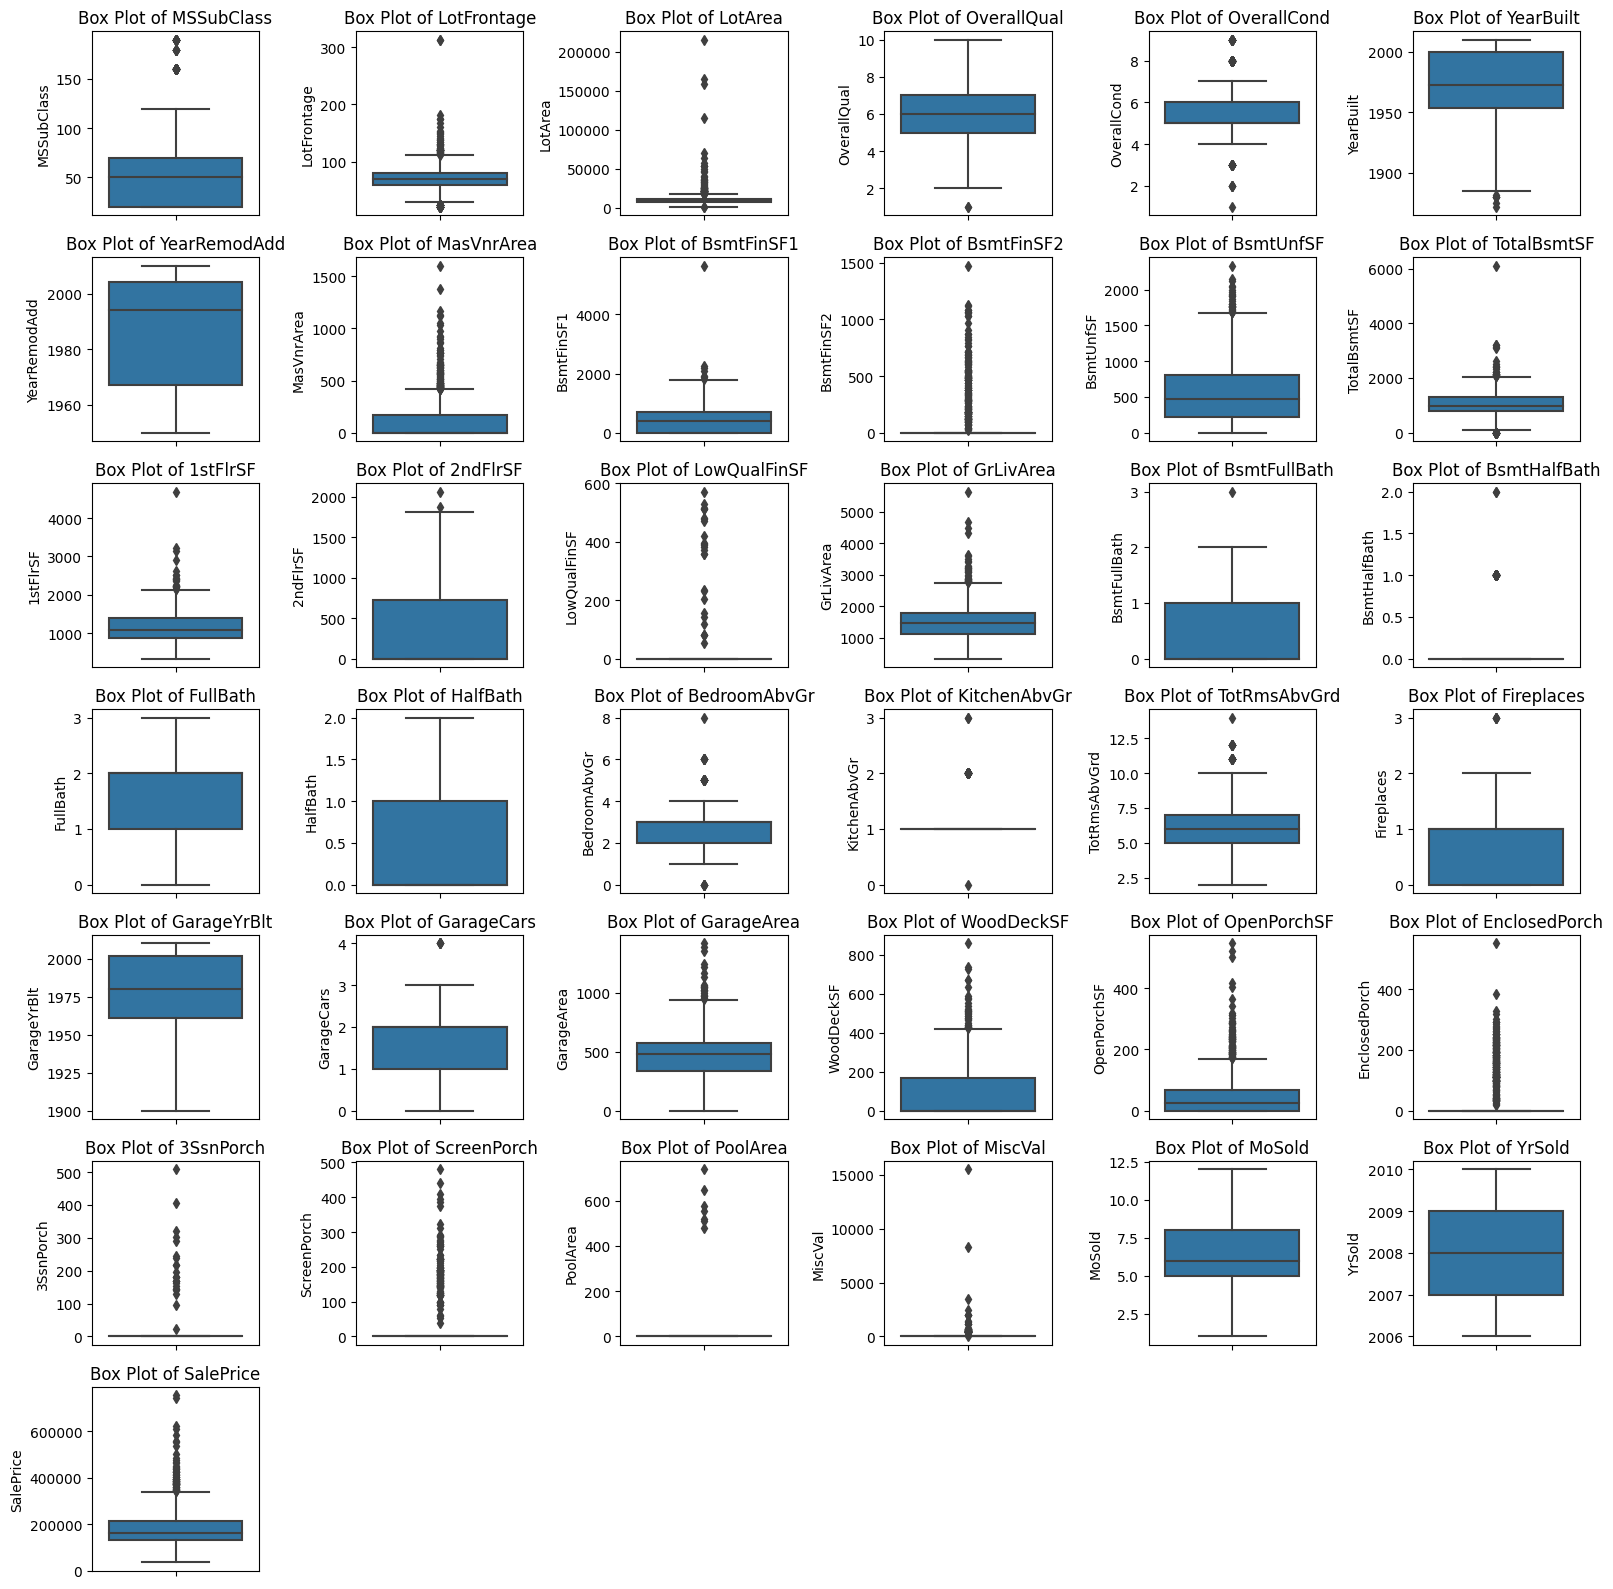

In [129]:
# Plot box plots for each numerical column
plt.figure(figsize=(16, 16))
for i, col in enumerate(dataset_numeric.columns):
    # Plot box plot
    plt.subplot(7, 6, i + 1)
    sns.boxplot(y=train_df[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

In [130]:
dataset_numeric.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Categorical columns

In [131]:
dataset_categorical = train_df.select_dtypes(include=['object'])
dataset_categorical.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [132]:
dataset_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   Alley          91 non-null     object
 3   LotShape       1460 non-null   object
 4   LandContour    1460 non-null   object
 5   Utilities      1460 non-null   object
 6   LotConfig      1460 non-null   object
 7   LandSlope      1460 non-null   object
 8   Neighborhood   1460 non-null   object
 9   Condition1     1460 non-null   object
 10  Condition2     1460 non-null   object
 11  BldgType       1460 non-null   object
 12  HouseStyle     1460 non-null   object
 13  RoofStyle      1460 non-null   object
 14  RoofMatl       1460 non-null   object
 15  Exterior1st    1460 non-null   object
 16  Exterior2nd    1460 non-null   object
 17  MasVnrType     1452 non-null   object
 18  ExterQual      1460 non-null

First check if all the columns of the training set are in the test set



In [133]:
def check_df_columns(dataset, cols):
    #Check if test df has the necessary columns as the train df
    if not set(cols).issubset(dataset.columns):
        for df_col in cols:
            if df_col not in dataset.columns:
                dataset[df_col] = 0.0
    new_cols = list(set(dataset.columns)-set(cols))
    if len(new_cols) > 0:
        dataset.drop([new_cols], axis=1, inplace=True)
    return dataset

#Apply function to ensure desired columns exist and there is no dimension error later
x_col = train_df.drop(['SalePrice'], axis=1)
test_df = check_df_columns(test_df, x_col.columns)

Drop columns with a lot of missing values

In [134]:
#Columns to drop
drop_columns = ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType']

train_df.drop(drop_columns, axis=1, inplace=True)
test_df.drop(drop_columns, axis=1, inplace=True)

Calculate replacement for neighborhood

In [135]:
def get_neighborhood_mean(dataset):
    #Get value to replace the neighborhood name
    neighs = dataset['Neighborhood'].unique()
    #Dict to save values per square meter
    neigh_mean_sale = {}
    #For each neighborhood calculate the mean price per lot area
    for nbhd in neighs:
        nbhd_mean = (dataset[dataset['Neighborhood']==nbhd]['SalePrice']/dataset[dataset['Neighborhood']==nbhd]['LotArea']).mean()
        neigh_mean_sale[nbhd] = nbhd_mean
    return neigh_mean_sale

#Replace neighborhood value with the median price per area
def replace_neighborhood(dataset, repl_dict):
    #Replace the neighborhood name with the price per area
    dataset.replace({'Neighborhood': repl_dict}, inplace=True)

#Use function above to get dict of $/m2
neighborhood_price_mean = get_neighborhood_mean(train_df)
#Replace neighborhood in both sets
replace_neighborhood(train_df, neighborhood_price_mean)
replace_neighborhood(test_df, neighborhood_price_mean)

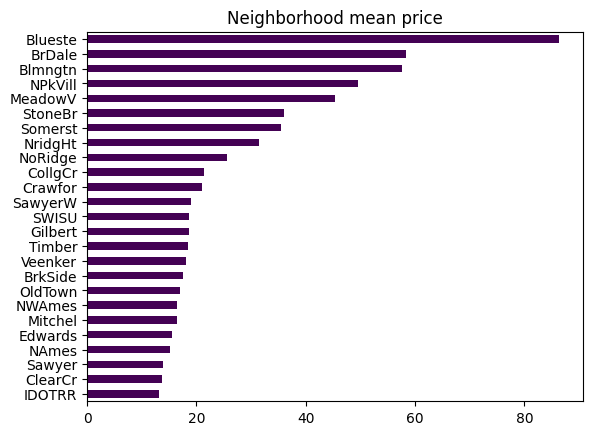

In [136]:
nbhd_data = pd.Series(neighborhood_price_mean).sort_values()
nbhd_data.plot(kind='barh', title = 'Neighborhood mean price', colormap = 'viridis');

Create new columns and remove redundant info

In [137]:
from datetime import date

#Start by creating more complete features from others that don't provide as much information
train_df['TotalProperySize'] = train_df['LotArea'] + train_df['1stFlrSF'] + train_df['2ndFlrSF'] + train_df['TotalBsmtSF']
train_df['TotalPorch'] = train_df['OpenPorchSF'] + train_df['EnclosedPorch'] + train_df['3SsnPorch'] + train_df['ScreenPorch']
train_df['TotalBathrooms'] = train_df['FullBath'] + 0.5 * train_df['HalfBath'] + train_df['BsmtFullBath'] + 0.5 * train_df['BsmtHalfBath']
train_df['Remodeled'] = train_df['YearRemodAdd'] > train_df['YearBuilt']
#MSSubClass is originally numerical but the numbers don't represent the "distances" or relative orders of categories
train_df['MSSubClass'] = train_df['MSSubClass'].astype(object)
train_df['YearSoldReal'] = train_df['YrSold'] + train_df['MoSold']/12
train_df['HouseAge'] = (date.today().year - train_df['YearBuilt']).astype(int)

#Apply same treatement to test df
test_df['TotalProperySize'] = test_df['LotArea'] + test_df['1stFlrSF'] + test_df['2ndFlrSF'] + test_df['TotalBsmtSF']
test_df['TotalPorch'] = test_df['OpenPorchSF'] + test_df['EnclosedPorch'] + test_df['3SsnPorch'] + test_df['ScreenPorch']
test_df['TotalBathrooms'] = test_df['FullBath'] + 0.5 * test_df['HalfBath'] + test_df['BsmtFullBath'] + 0.5 * test_df['BsmtHalfBath']
test_df['Remodeled'] = (test_df['YearRemodAdd'] > test_df['YearBuilt']).astype(int)
#MSSubClass is originally numerical but the numbers don't represent the "distances" or relative orders of categories
test_df['MSSubClass'] = test_df['MSSubClass'].astype(object)
test_df['YearSoldReal'] = test_df['YrSold'] + test_df['MoSold']/12
test_df['HouseAge'] = (date.today().year - test_df['YearBuilt']).astype(int)

redundant_cols = ['LotArea', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'YearRemodAdd', 'YearBuilt', 'YrSold', 'MoSold']

Impute missing values

In [138]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

numerical_colss = train_df.select_dtypes('number').columns

#Impute missing numerical values with the median of the column
numerical_imputer = SimpleImputer(strategy='median')
#Impute missing categorical values with the most frequent (mode)
mode_imputer = SimpleImputer(strategy='most_frequent')
#Impute missing categorical values (related to Garage, Basement, Fireplace) that have NA if they don't exist in the house
inexistent_imputer = SimpleImputer(strategy='constant', fill_value='None')
inexistent_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                  'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

#Get numerical columns from test set to avoid using SalePrice
numerical_cols = test_df.select_dtypes('number').columns
train_df[numerical_cols] = numerical_imputer.fit_transform(train_df[numerical_cols])
test_df[numerical_cols] = numerical_imputer.fit_transform(test_df[numerical_cols])

#Impute inexistent values in BGF columns
train_df[inexistent_cols] = inexistent_imputer.fit_transform(train_df[inexistent_cols])
test_df[inexistent_cols] = inexistent_imputer.fit_transform(test_df[inexistent_cols])

#Impute the rest of categorical values
categorical_cols = train_df.select_dtypes('object').columns
train_df[categorical_cols] = mode_imputer.fit_transform(train_df[categorical_cols])
test_df[categorical_cols] = mode_imputer.fit_transform(test_df[categorical_cols])

In [139]:
train_df_cat = train_df.copy()
test_df_cat = test_df.copy()

Convert categorical features to ordinal



In [140]:
def replace_ordinal_feats(data):
    #Dictionaries to convert categorical values to strings
    dict_street = {'Grvl':0, 'Pave':1}
    dict_lot_shape = {'Reg':0, 'IR1':1, 'IR2':2, 'IR3':3}
    dict_utilities = {'AllPub':0, 'NoSewr':1, 'NoSeWa':2, 'ELO':3}
    dict_qual_cond = {'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'None':5}
    dict_exposure = {'Gd':0, 'Av':1, 'Mn':2, 'No':3, 'None':3}
    dict_finish = {'GLQ':0, 'ALQ':1, 'BLQ':2, 'Rec':3, 'LwQ':4, 'Unf':5, 'None':6}
    dict_air = {'Y':0, 'N':1}
    dict_electrical = {'SBrkr':0, 'FuseA':1, 'FuseF':2, 'FuseP':3, 'Mix':4}
    dict_functional = {'Typ':0, 'Min1':1, 'Min2':2, 'Mod':3, 'Maj1':4, 'Maj2':5, 'Sev':6, 'Sal':7}
    dict_gar_finish = {'Fin':0, 'RFn':1, 'Unf':2, 'None':3}
    dict_pave = {'Y':0, 'P':1, 'N':2}

    #Tuples with dicts corresponding to each column to convert
    replace_columns = [('Street', dict_street), ('LotShape', dict_lot_shape), ('Utilities', dict_utilities),\
                      ('ExterQual', dict_qual_cond), ('ExterCond', dict_qual_cond), ('BsmtQual', dict_qual_cond),\
                      ('BsmtCond', dict_qual_cond), ('BsmtExposure', dict_exposure), ('BsmtFinType1', dict_finish),\
                      ('HeatingQC', dict_qual_cond), ('CentralAir', dict_air), ('Electrical', dict_electrical),\
                      ('KitchenQual', dict_qual_cond), ('Functional', dict_functional), ('FireplaceQu', dict_qual_cond),\
                      ('GarageFinish', dict_gar_finish), ('GarageQual', dict_qual_cond), ('GarageCond', dict_qual_cond),\
                      ('PavedDrive', dict_pave)]

    #Replace categoricals with integers
    for (col, repl_dict) in replace_columns:
        data.replace({col: repl_dict}, inplace=True)

#Apply to datasets
replace_ordinal_feats(train_df)
replace_ordinal_feats(test_df)

One-hot encoding

In [141]:
#Get remaining categorical columns
categorical_columns = train_df.select_dtypes('object').columns

#Define and train One hot encoder
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int).fit(train_df[categorical_columns])

#Transform selected portion of dataframes
transformed_train = enc.transform(train_df[categorical_columns].to_numpy())
transformed_test = enc.transform(test_df[categorical_columns].to_numpy())

#Get feature names for new columns
new_cols = enc.get_feature_names_out()

#Create a Pandas DataFrames of the hot encoded columns
ohe_train_df = pd.DataFrame(transformed_train.reshape(-1,len(new_cols)), columns=new_cols)
ohe_test_df = pd.DataFrame(transformed_test.reshape(-1,len(new_cols)), columns=new_cols)

#Drop categorical columns
train_df.drop(list(categorical_columns.values), axis=1, inplace=True)
test_df.drop(list(categorical_columns.values), axis=1, inplace=True)

#Concat with original data
train_df = pd.concat([train_df, ohe_train_df], axis=1)
test_df = pd.concat([test_df, ohe_test_df], axis=1)

In [143]:
#Get columns to scale
numeric_columns = train_df.select_dtypes('number').columns

scaler = MinMaxScaler() #we could use StandardScaler instead but it removes outliers by scaling the variance
scaler.fit(train_df[numeric_columns])

#Apply scaling
train_df[numeric_columns] = scaler.transform(train_df[numeric_columns])

Train-Validation split data